<a href="https://colab.research.google.com/github/jkjh23/BusanAIDeveloperCourse_AI/blob/master/3_DeepLearning/11-1_LSTM_Retail%20trade%20sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경설정

In [ ]:
import keras
keras.__version__

'2.4.3'

In [ ]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Time Series Forcating
- 날짜별로 특정한 값이 있는 데이터
  - Unadjusted가 Raw값, Seasonally adjusted는 Season의 효과를 보정한 값
  - 보통 주식과 같은 시계열 데이터는 Season에 의한 효과가 있는데, Seasonally adjusted는 이 Season에 의한 효과를 보정하여 전체적인 추세만 보고자할 때 사용하는 변수다.
- [Retail trade sales by province and territory](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2010000801)

In [ ]:
from pandas.tseries.offsets import MonthEnd
dir = '/content/drive/My Drive/2020_AI_Busan/4_DeepLearning/LSTM_Data/08_04_Advanced_Model-LSTM_cansim-0800020-eng-6674700030567901031.csv'
df = pd.read_csv(dir, skiprows=6, skipfooter=9, engine='python')
df

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083
...,...,...,...
308,Sep-2016,45528702,44534797
309,Oct-2016,44770113,45061618
310,Nov-2016,46285062,45141762
311,Dec-2016,50016137,44943929


# 전처리
- 문자열로 된 Adjustments 컬럼을 datetime 객체로 변환
- MonthEnd(1)을 더하면 해당 월의 마지막 날짜가 지정되게 하여, 이 날짜를 index로 만든다.

In [ ]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083
...,...,...
2016-09-30,45528702,44534797
2016-10-31,44770113,45061618
2016-11-30,46285062,45141762


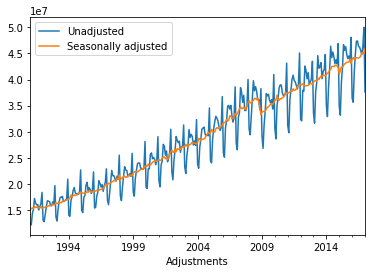

In [ ]:
df.plot()

## 트레이닝, 테스트 세트 만들기 
- Split
- 2011/1/1을 기준으로 트레이닝세트와 테스트세트로 구분
- 학습과 테스트에 사용할 Unadjusted 변수만 남긴다.

In [ ]:
split_date = pd.Timestamp('01-01-2011')

In [ ]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]
train.head(), test.head()

(             Unadjusted
 Adjustments            
 1991-01-31     12588862
 1991-02-28     12154321
 1991-03-31     14337072
 1991-04-30     15108570
 1991-05-31     17225734,              Unadjusted
 Adjustments            
 2011-01-31     31191594
 2011-02-28     29797949
 2011-03-31     36099866
 2011-04-30     38035760
 2011-05-31     40046516)

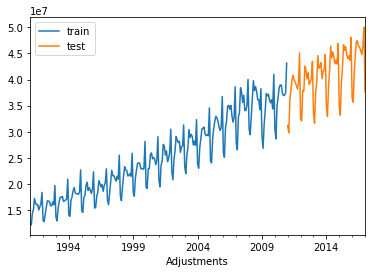

In [ ]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

## Scaling
- MinMax Scaling을 통해 변수를 Scaling한다.
- Scaling한 데이터는 2차원 numpy ndarray 타입으로 변환하다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [ ]:
train_sc = sc.fit_transform(train)
test_sc = sc.fit_transform(test)

## DataFrame 변환
- DataFrame 변환 처리를 해야 Window를 만들기 유용하다.
- Window는 순환신경망 트레이닝하기 위한 단위로 Window Size는 TimeStep과 같다고 생각하면 된다.

In [ ]:
train_sc_df = pd.DataFrame(train_sc, columns = ['Scaled'], index = train.index)
test_sc_df = pd.DataFrame(test_sc, columns = ['Scaled'], index = test.index)
print(train_sc_df.head())
print(test_sc_df.head())

               Scaled
Adjustments          
1991-01-31   0.014020
1991-02-28   0.000000
1991-03-31   0.070426
1991-04-30   0.095318
1991-05-31   0.163628
               Scaled
Adjustments          
2011-01-31   0.068930
2011-02-28   0.000000
2011-03-31   0.311695
2011-04-30   0.407446
2011-05-31   0.506898


## Window
- pandas shift를 통해 Window를 만든다.
- shift는 이전 정보를 다음 row에서 다시 쓰기 위한 pandas의 함수
- 과거의 값을 shift_s와 같은 형태로 저장할 수 있다.
- 과거값은 총 12개를 저장하여, timestep은 12개가 된다.
- 과거값 shift1-12를 통해 현재 값 Scaled를 예측한다.

In [ ]:
for s in range(1, 13) :
  train_sc_df[f'shift_{s}'] = train_sc_df['Scaled'].shift(s)
  test_sc_df[f'shift_{s}']  = test_sc_df['Scaled'].shift(s)
print(train_sc_df)
print(test_sc_df)

               Scaled   shift_1   shift_2  ...  shift_10  shift_11  shift_12
Adjustments                                ...                              
1991-01-31   0.014020       NaN       NaN  ...       NaN       NaN       NaN
1991-02-28   0.000000  0.014020       NaN  ...       NaN       NaN       NaN
1991-03-31   0.070426  0.000000  0.014020  ...       NaN       NaN       NaN
1991-04-30   0.095318  0.070426  0.000000  ...       NaN       NaN       NaN
1991-05-31   0.163628  0.095318  0.070426  ...       NaN       NaN       NaN
...               ...       ...       ...  ...       ...       ...       ...
2010-08-31   0.814394  0.863983  0.865311  ...  0.773687  0.754447  0.770968
2010-09-30   0.799167  0.814394  0.863983  ...  0.716290  0.773687  0.754447
2010-10-31   0.802101  0.799167  0.814394  ...  0.929722  0.716290  0.773687
2010-11-30   0.814829  0.802101  0.799167  ...  0.597349  0.929722  0.716290
2010-12-31   1.000000  0.814829  0.802101  ...  0.531665  0.597349  0.929722

## 트레이닝, 테스트 세트 만들기 
- dropna를 이용하여 NaN이 있는 데이터를 제거
- shift1-12는 X로, Scaled는 Y로 지정

In [ ]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]
X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [ ]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [ ]:
y_train.head()

,Scaled
Adjustments,
1992-01-31,0.030027
1992-02-29,0.019993
1992-03-31,0.065964
1992-04-30,0.109831
1992-05-31,0.149130


## 다시 ndarray로 변환
- 실제 deep learning 모델의 트레이닝과 테스트로 사용되는 데이터는 일반적으로 ndarray이다.


In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
# 트레이닝 데이터는 timestep = 12, size = 228
X_train.shape

(228, 12)

## 트레이닝, 테스트 세트 만들기 - 최종
- keras에서는 모델을 트레이닝할 때 요구되는 데이터의 형식이 있다.
  - 3차원의 데이터여야 한다.
  - 각각의 차원은 "size", "timestep", "feature" 순서대로 나타내야 한다.
- 일반적인 MLP 모델에서는 size와 feature만 있지만, 순환신경망에서는 "시간"이라는 개념이 있기 때문에 차원이 한 차원 늘어나게 된다.

In [ ]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t  = X_test.reshape(X_test.shape[0], 12, 1)

In [ ]:
X_train_t.shape

(228, 12, 1)

# LSTM 모델 만들기
- input_shape=(timestep, feature)로 만든다.
  - size는 모델 설계 시에는 중요하지 않으므로, feature, timestep만 모델에 알려주면 된다.
- 예측하고자 하는 target의 개수가 1이므로 마지막에 Dense(1)을 추가
- 실제 연속적인 값을 예측하는 것이기 때문에 loss function은 Mean squared error가 되고, 일반적으로 optimizer는 adam을 자주 사용한다.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [ ]:
K.clear_session()
model = Sequential()
model.add(LSTM(6, input_shape = (12, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

## 모델 Fitting
- Fitting은 training dataset으로 optization 과정을 통해 모델의 weight를 찾는 것이다.
- early stopping 객체를 이용해 epoch마다 early stopping을 체크한다.

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [ ]:
model.fit(X_train_t, y_train, epochs=600, batch_size=32, verbose=0)

# 테스트
- 학습된 모델을 통해 테스트세트로 테스트하기
  - 테스트세트는 2011/1/1 이후 데이터를 나타낸다.
  - 트레이닝에는 1991년부터 2010년까지의 데이터가 이용되었다.
  - 예측은 1991-2010년 데이터를 통해 2011년 이후 데이터를 예측하는 것으로 볼 수 있다.

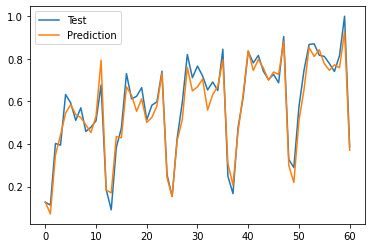

In [ ]:
y_pred = model.predict(X_test_t)
plt.plot(y_test, label='Test')
plt.plot(y_pred, label='Prediction')
plt.legend(loc='upper left')